In [1]:
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumRegister, QuantumCircuit, Aer, execute
from qiskit.compiler import transpile
from qiskit.providers.aer import noise
from qiskit.providers.aer.noise import NoiseModel
import qiskit.ignis.verification.quantum_volume as qv
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

S_simulator = Aer.get_backend('statevector_simulator')
M_simulator = Aer.get_backend('qasm_simulator')

# 6. Quantum System Error Analysis

---
## Question 6.1

**The image below shows the calibration matrix for two qubits. What kind of noise caused this?**

**Remember that a short decay time means more of the noise can be expected to have happened.
Also note that in Qiskit qubit ordering is `q1q0`, e.g. $|01 \rangle$ means `q1` is $|0 \rangle$ and `q0` is $|1 \rangle$.**

<img src="..\questions\error_analysis_images\calib.png" align="left" width="300"/>

**1)** Qubits in state $| 1 \rangle $ decay down to $| 0 \rangle $ before measurement. The decay times for both qubits are equal.

**2)** Qubits in state $| 0 \rangle $ decay down to $| 1 \rangle $ before measurement. The decay time for `q0` is shorter than that for `q1`.

**3)** Qubits in state $| 1 \rangle $ decay down to $| 0 \rangle $ before measurement. The decay time for `q0` is longer than that for `q1`.

**4)** Qubits in state $| 0 \rangle $ decay down to $| 1 \rangle $ before measurement. The decay time for `q0` is longer than that for `q1`.

**5)** Qubits in state $| 1 \rangle $ decay down to $| 0 \rangle $ before measurement. The decay time for `q0` is shorter than that for `q1`.

### Solution to Q6.1:

From the calibration matrix above, we can clearly see that, for the prepared state $|00 \rangle$, we measure the same state $|00 \rangle$ with probability 1. This means that it is very likely that we are not seeing qubits in state $|0 \rangle $ "decay" to stay $|1 \rangle $ (this will actually correspond to an excitation). This means we can rule out **options 2, 3**.

Next, we can see that when we prepare state $|01 \rangle$, we measure the state $|00 \rangle$ with probability of about 0.3. In contrast, when we prepare state $|10 \rangle$, we measure the state $|00 \rangle$, but with much lower probability (somewhere around 0.1). This means that `q0` has a shorter decay time than `q1`.

### Answer to Q6.1:

**5)** Qubits in state $| 1 \rangle $ decay down to $| 0 \rangle $ before measurement. The decay time for `q0` is shorter than that for `q1`.

---
## Question 6.2

**The noise that caused the calibration matrix in the previous question depends on an array of $T_1$ times, where the element `T1[j]` is the decay time of the qubit `qr[j]` during measurement. Once this has been defined, the noise is simulated with**

```
T2 = [1,1] # arbitrarily chosen T2 times
time_measure = 10 # arbitrarily chosen measurement time
noise_thermal = NoiseModel()
for j in range(2):
    noise_thermal.add_quantum_error(thermal_relaxation_error(T1[j], T2[j], time_measure) , "measure", [j])
```

**Which $T_1$ times create a calibration matrix closest to the one shown above?**

**1)** `[100,30]`

**2)** `[50,3]`

**3)** `[3,10]`

**4)** `[30,100]`

**5)** `[1,1000]`

### Solution for Q6.2:

From question 6.1, we know that the value of the first item in the T1 array should be smaller than the second one. This corresponds to **options 3, 4, 5**. **Option 5** seems disproportionate in terms of decay times, making it an unlikely option, but the ratios for **options 3, 4** are the same, so it is difficult to tell which one is correct. For this reason, we are actually going to have to run the code to generate this calibration matrix.

First, we create the noiseless calibration circuit. This should generate the identity matrix:

In [2]:
qr = QuantumRegister(2)
qubit_list = [0,1]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')

job = execute(meas_calibs, backend=M_simulator, shots=1024)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


Next, we generate the noise model using the code defined by the problem in hand. We will select **option 4** as the input to T1 as it seems to be the most reasonable selection (if this doesn't give us the right calibration map, we can then execute the same code for **option 3**):

In [3]:
# Code snipet from the problem statement
# we are only adding the T1 array

noise_thermal = noise.NoiseModel()

T1 = [30, 100]     # Option 4 from the available answers
T2 = [1,1]         # arbitrarily chosen T2 times
time_measure = 10  # arbitrarily chosen measurement time

for j in range(2):
    noise_thermal.add_quantum_error(noise.thermal_relaxation_error(T1[j], T2[j], time_measure) , "measure", [j])

Now we execute the calibration circuits, and extract the calibration matrix with the added noise model

In [4]:
backend = Aer.get_backend('qasm_simulator')
job = execute(meas_calibs, backend=backend, shots=1024, noise_model=noise_thermal)
cal_results = job.result()

meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

[[1.         0.28417969 0.07421875 0.03222656]
 [0.         0.71582031 0.         0.07617188]
 [0.         0.         0.92578125 0.25      ]
 [0.         0.         0.         0.64160156]]


Now, we can plot the resulting calibration matrix:

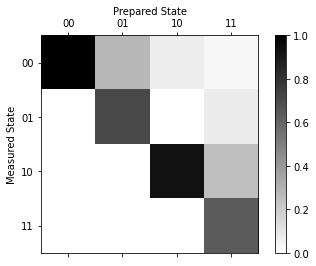

In [5]:
meas_fitter.plot_calibration()

### Answer for Q6.2:

**4)** `[30,100]`

---
## Question 6.3

**To calculate Quantum Volume, we test whether a certain condition is satisfied for random circuits applied to successivly larger sets of qubits. These can be made out of any qubits you have available. For example, the tutorial on quantum volume uses**
           `qubit_lists = [[0,1,3],[0,1,3,5],[0,1,3,5,7],[0,1,3,5,7,10]]`
   
Let's extend the 2-qubit noise model from the previous question to 5 qubits.

```
n = 5
T1 =  [ j*20 for j in range(1,n+1) ]
T2 = [ 2*t1 for t1 in T1] # T2 times as large as they can be
time_measure = 10 # arbitrarily chosen measurement time
noise_thermal = NoiseModel()
for j in range(n):
    noise_thermal.add_quantum_error( thermal_relaxation_error(T1[j], T2[j], time_measure) , "measure", [j])

```

**Which of the following would be most sensible for calculating quantum volume, given the decay times on each qubit?**

**1)**  `[[0,2,4],[0,2,3,4],[0,1,2,3,4]]`

**2)**  `[[0,1,2],[0,1,2,3],[0,1,2,3,4]]`

**3)**  `[[0,2,4],[0,1,2,4],[0,1,2,3,4]]`

**4)**  `[[2,3,4],[1,2,3,4],[0,1,2,3,4]]`

**5)**  None of the above

### Solution for Q6.3:



Since we are trying to find what is the maximum achievable quantum volume (QV) with the qubits we have available, we should pick the combination of qubits that have the longest decay times. From the code above, we see that the decay time for each qubit is longer as the qubit number increases:

In [6]:
n = 5
T1 =  [ j*20 for j in range(1,n+1) ]
print(T1)

[20, 40, 60, 80, 100]


This means that a qubit list containing combinations with higher qubit numbers, will give us a much better chance of finding what the maximum QV we can get for the system. This suggests that **option 4** (which contains the unique combinations of higher qubit numbers: `[2,3,4]` and `[1,2,3,4]`) will be the best choice.

Now, to be on the safe side, we can actually run the code to estimate the quantum volume for each possible combination, and make sure **option 4** is in fact the better one.

See this [tutorial](https://qiskit.org/documentation/tutorials/noise/5_quantum_volume.html) for a clear explanation of how the code below works.

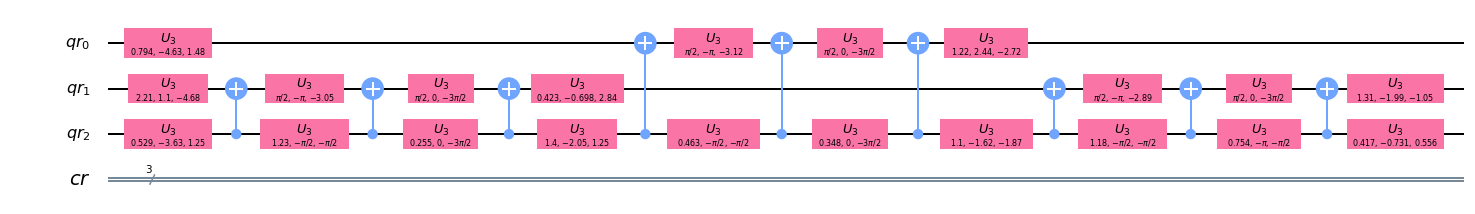

In [7]:
qubit_lists = [[2,3,4],[1,2,3,4],[0,1,2,3,4]] # qubit list (this is option 4 from the available answers)
ntrials = 50

qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)

#pass the first trial of the nomeas through the transpiler to illustrate the circuit
qv_circs_nomeas[0] = transpile(qv_circs_nomeas[0], basis_gates=['u3','cx'])

# Draw sample circuit
qv_circs_nomeas[0][0].draw('mpl', fold = 100)

In [8]:
# Simulate ideal model
ideal_results = []
for trial in range(ntrials):
    print('Simulating trial %d'%trial)
    ideal_results.append(execute(qv_circs_nomeas[trial], backend=S_simulator, optimization_level=0).result())

Simulating trial 0
Simulating trial 1
Simulating trial 2
Simulating trial 3
Simulating trial 4
Simulating trial 5
Simulating trial 6
Simulating trial 7
Simulating trial 8
Simulating trial 9
Simulating trial 10
Simulating trial 11
Simulating trial 12
Simulating trial 13
Simulating trial 14
Simulating trial 15
Simulating trial 16
Simulating trial 17
Simulating trial 18
Simulating trial 19
Simulating trial 20
Simulating trial 21
Simulating trial 22
Simulating trial 23
Simulating trial 24
Simulating trial 25
Simulating trial 26
Simulating trial 27
Simulating trial 28
Simulating trial 29
Simulating trial 30
Simulating trial 31
Simulating trial 32
Simulating trial 33
Simulating trial 34
Simulating trial 35
Simulating trial 36
Simulating trial 37
Simulating trial 38
Simulating trial 39
Simulating trial 40
Simulating trial 41
Simulating trial 42
Simulating trial 43
Simulating trial 44
Simulating trial 45
Simulating trial 46
Simulating trial 47
Simulating trial 48
Simulating trial 49


In [10]:
# Load ideal results into quantum volume fitter
qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

# Generate a noise model for the 5 qubits (this is taken from the TEST Question!!)
noise_thermal = noise.NoiseModel()

n = 5
T1 =  [ j*20 for j in range(1,n+1) ]
T2 = [ 2*t1 for t1 in T1]             # T2 times as large as they can be
time_measure = 10                     # arbitrarily chosen measurement time

for j in range(n):
    noise_thermal.add_quantum_error(noise.thermal_relaxation_error(T1[j], T2[j], time_measure) , "measure", [j])

In [11]:
# Execute the noisy QV sequence in qsam_simulator
basis_gates = ['u3','cx'] # use U,CX for now
exp_results = []
for trial in range(ntrials):
    print('Running trial %d'%trial)
    exp_results.append(execute(qv_circs[trial], basis_gates=basis_gates, 
                                      backend=M_simulator, noise_model=noise_thermal, 
                                      backend_options={'max_parallel_experiments': 0}).result())

Running trial 0
Running trial 1
Running trial 2
Running trial 3
Running trial 4
Running trial 5
Running trial 6
Running trial 7
Running trial 8
Running trial 9
Running trial 10
Running trial 11
Running trial 12
Running trial 13
Running trial 14
Running trial 15
Running trial 16
Running trial 17
Running trial 18
Running trial 19
Running trial 20
Running trial 21
Running trial 22
Running trial 23
Running trial 24
Running trial 25
Running trial 26
Running trial 27
Running trial 28
Running trial 29
Running trial 30
Running trial 31
Running trial 32
Running trial 33
Running trial 34
Running trial 35
Running trial 36
Running trial 37
Running trial 38
Running trial 39
Running trial 40
Running trial 41
Running trial 42
Running trial 43
Running trial 44
Running trial 45
Running trial 46
Running trial 47
Running trial 48
Running trial 49


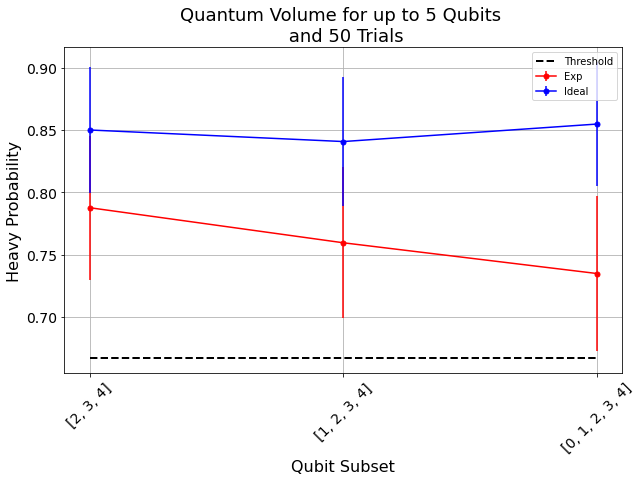

In [12]:
# Load the experimental data into the fitter and plot results
qv_fitter.add_data(exp_results)

plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the essence by calling plot_rb_data
qv_fitter.plot_qv_data(ax=ax, show_plt=False)

# Add title and label
ax.set_title('Quantum Volume for up to %d Qubits \n and %d Trials'%(len(qubit_lists[-1]), ntrials), fontsize=18)

plt.show()

In [13]:
# Identify which of the combination of qubits provided meets criteria, and what is the QV if criteria is met

qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
QV = 1
for qidx, qubit_list in enumerate(qubit_lists):
    if qv_list[0][qidx]>2/3:
        if qv_success_list[qidx][0]:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (successful). Quantum volume %d"%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1],qv_fitter.quantum_volume()[qidx]))
            QV = qv_fitter.quantum_volume()[qidx]
        else:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (unsuccessful)."%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1]))
    else:
        print("Width/depth %d less than 2/3 (unsuccessful)."%len(qubit_list))

Width/depth 3 greater than 2/3 (0.787637) with confidence 0.981759 (successful). Quantum volume 8
Width/depth 4 greater than 2/3 (0.759492) with confidence 0.937703 (unsuccessful).
Width/depth 5 greater than 2/3 (0.734824) with confidence 0.862538 (unsuccessful).


In [14]:
print ("The Quantum Volume is:", QV)

The Quantum Volume is: 8


### Answer for Q6.3:

**4)** `[[2,3,4],[1,2,3,4],[0,1,2,3,4]]`